In [1]:
import sys
sys.path.append('C:/Users/james/OneDrive/바탕 화면/대학교/수업/2024-1/물류관리/Term_project/Modules')

import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import combinations
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from utils import *

from savings.link import Link
from savings.node import Node
from savings.graph import Graph
from savings.SavingsModel import SavingsModel

from savings.SavingsAlgorithm import Clarke_Wright_Savings

In [5]:
DEPOT_INDEX = 0 # 창고의 data상 index
DEMAND_CV = 0 # 수요 발생의 변동계수(CV)값 설정
DEMAND_COEFFICIENT = 1 # 수요 발생량에 대해 적절히 곱해주기 위함
ROUTE_TYPE = 'trafast' # route 탐색 방식
JSON_PATH = './../Data/routes_with_depot' # JSON 파일들이 있는 폴더 경로
TRUCK_CAPA = 11560 # 한 트럭이 실을 수 있는 적재 capacity (L)
MAX_TIME = 8 * 60 * 60 * 1000 # ms 단위 최대 트럭 운전 시간
SERVICE_TIME = 2*60*1000 # ms 단위 node별 서비스 시간
DRIVER_SALARY = 35000000
STOCHASTIC_DROP = 0.1 # drop 비율

node_data = pd.read_csv('./../Data/data_with_depot.csv')

In [6]:
# 문제 상황에 대한 Graph 객체 만들기
g = Graph()

# Node 등록
for row in node_data.iterrows():
    data = row[1]

    # Node 생성 후 등록
    n = Node(data['index'], data['longitude'], data['latitude'])
    n.generate_demand(data['demand_mu']*DEMAND_COEFFICIENT, data['capacity'], DEMAND_CV)
    g.add_node(n)

# Link 등록
for n1, n2 in tqdm([comb for comb in combinations(g.nodes, 2)]):
    if n1.index > n2.index:
        temp = n2
        n2 = n1
        n1 = temp

    link_cost, link_time = get_cost_time(n1.index, n2.index, ROUTE_TYPE, JSON_PATH, toll_include=True)
    l = Link(n1, n2, link_cost, link_time)
    g.add_link(l)

# 임시: depot의 demand는 0으로 설정
g.get_node(DEPOT_INDEX).demand = 0

100%|██████████| 2145/2145 [00:15<00:00, 140.11it/s]


In [11]:
# saving 모델 정의 및 돌리기
svm = SavingsModel(g, DEPOT_INDEX)
svm.calculate_savings()
svm.apply_algorithm(TRUCK_CAPA, Clarke_Wright_Savings, MAX_TIME, SERVICE_TIME)
print('[Clarke_Wright_Saving의 Cost 초기해]')
svm.yearly_cost(MAX_TIME, fixed=int(DRIVER_SALARY), verbose=False)
for rs in svm.merged_routes:
    for r in rs:
        print(r)
    print('\n')

print(f'최대 적재량 {TRUCK_CAPA:,}L\n운송비 {svm.cost:,}원\n총 수거 {round(svm.demand):,}L')

# stochastic 모델
if (STOCHASTIC_DROP!=0):
    print('\n[Stochastic Model]')
    lowest = svm.yearly_cost(MAX_TIME, fixed=int(DRIVER_SALARY), verbose=True)
    lowest_svm = None

    for i in tqdm(range(100)):
        stochastic_svm = SavingsModel(g, DEPOT_INDEX)
        stochastic_svm.calculate_savings()
        stochastic_svm.apply_algorithm(TRUCK_CAPA, Clarke_Wright_Savings, MAX_TIME, SERVICE_TIME, stochastic_drop=STOCHASTIC_DROP)
        sto_cost = stochastic_svm.yearly_cost(MAX_TIME, fixed=int(DRIVER_SALARY), verbose=True)
        if lowest > sto_cost:
            lowest = sto_cost
            lowest_svm = stochastic_svm
            print('better solution found')
            print(f'Better Cost : {sto_cost:,}')

    print('\n[Total Saved from stochastic C&W method]')
    print(f'{svm.yearly_cost(MAX_TIME, fixed=int(DRIVER_SALARY), verbose=True)-lowest:,}원')

[Clarke_Wright_Saving의 Cost 초기해]
연간 운송비: 38,657,150원
연간 인건비: 105,000,000원
연간 총 비용: 143,657,150원
Route : 0 - 11 - 6 - 9 - 16 - 44 - 2 - 3 - 5 - 4 - 27 - 20 - 30 - 29 - 22 - 39 - 32 - 54 - 42 - 23 - 19 - 14 - 15 - 1 - 45 - 24 - 26 - 33 - 49 - 43 - 31 - 25 - 0
Demand met : 1618.9775828850002, Cost : 32666, Time 6H 51M


Route : 0 - 18 - 28 - 38 - 37 - 17 - 48 - 40 - 47 - 41 - 8 - 12 - 50 - 53 - 10 - 52 - 0
Demand met : 900.6742813499999, Cost : 45314, Time 7H 1M


Route : 0 - 59 - 64 - 61 - 65 - 58 - 55 - 57 - 60 - 63 - 62 - 56 - 35 - 21 - 36 - 34 - 46 - 7 - 51 - 13 - 0
Demand met : 2397.873554632, Cost : 27930, Time 5H 47M


최대 적재량 11,560L
운송비 105,910원
총 수거 4,918L

[Stochastic Model]


  6%|▌         | 6/100 [00:04<01:03,  1.48it/s]

better solution found
Better Cost : 143,500,200


 14%|█▍        | 14/100 [00:09<00:58,  1.47it/s]

better solution found
Better Cost : 143,217,690


 54%|█████▍    | 54/100 [00:41<00:33,  1.37it/s]

better solution found
Better Cost : 141,338,670


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


[Total Saved from stochastic C&W method]
2,318,480원


In [12]:
for rs in lowest_svm.merged_routes:
    for r in rs:
        print(r)
    print('\n')

print(f'최대 적재량 {TRUCK_CAPA:,}L\n운송비 {lowest_svm.cost:,}원\n총 수거 {round(lowest_svm.demand):,}L')
lowest_svm.yearly_cost(MAX_TIME, fixed=int(35000000), verbose=False)

Route : 0 - 52 - 28 - 18 - 38 - 17 - 48 - 8 - 41 - 47 - 40 - 50 - 12 - 37 - 53 - 10 - 0
Demand met : 900.67428135, Cost : 46037, Time 7H 28M


Route : 0 - 4 - 5 - 3 - 11 - 6 - 9 - 16 - 44 - 2 - 32 - 54 - 42 - 23 - 19 - 14 - 15 - 39 - 22 - 29 - 30 - 1 - 45 - 20 - 27 - 24 - 26 - 33 - 13 - 49 - 43 - 31 - 25 - 0
Demand met : 1735.3193232849999, Cost : 31850, Time 6H 51M


Route : 0 - 64 - 61 - 65 - 58 - 55 - 57 - 60 - 63 - 62 - 59 - 56 - 35 - 21 - 36 - 34 - 46 - 7 - 51 - 0
Demand met : 2281.5318142319993, Cost : 21671, Time 5H 10M


최대 적재량 11,560L
운송비 99,558원
총 수거 4,918L
연간 운송비: 36,338,670원
연간 인건비: 105,000,000원
연간 총 비용: 141,338,670원


141338670

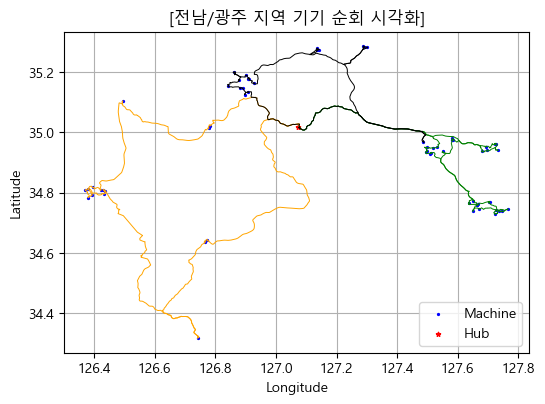

In [14]:
# figsize 비율 계산
ratio = (node_data.latitude.max() - node_data.latitude.min()) / (node_data.longitude.max() - node_data.longitude.min())
scale = 6

# fig, ax 객체 생성
fig, ax = plt.subplots(figsize=(scale, scale * ratio))

# 차량의 color 팔레트 지정
color_pallete = ['green', 'orange', 'black', 'purple', 'olive', 'gray', 'skyblue', 'green', 'orange', 'black', 'purple', 'olive', 'gray', 'skyblue']

# 데이터 플롯
ax.scatter(node_data['longitude'], node_data['latitude'], s=1.8, c='blue', label='Machine')
ax.scatter(svm.depot.x, svm.depot.y, s=10, c='red', label='Hub', marker='*')

# 축 레이블, 제목 및 범례 설정
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('[전남/광주 지역 기기 순회 시각화]', fontsize=12)
ax.grid()

# 그래프를 보여줍니다.
ax.legend(loc='lower right')

# 각 route를 visualize
for i, m_routes in enumerate(svm.merged_routes):
    for route in m_routes:
        route.visualize(ax, JSON_PATH, route_option='trafast', update_sec = 0.05, color = color_pallete[i])